![header](https://drive.google.com/uc?export=view&id=1KuEspEp7OwqGw6uMRJvYE6BVE-Zo-8JF)

 <h1> <div align="center"> Dr. David Antonio-Torres</div> </h1>

# Actividad 4.1 - Ejercicio de clasificación con Keras

Cervantes Castillo, José Ramón - 	A01683383

Esses Cohen, Abraham	-	A01018853

Lucas Dophe, Carolina		-	A01702450

Pedroza Rivera, Jorge		-	A01319553


# Bibliotecas necesarias

In [ ]:
# Se agregan las bibliotecas necesarias

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
from google.colab import drive
drive.mount('/content/drive')
import xml.etree.ElementTree as ET
import os
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical

# para el generador de aleatorios
np.random.seed(0)

Mounted at /content/drive


In [ ]:
# Se incluye el acceso a Drive de Google para acceder a los archivos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importación de los dos datasets para la detección de peatones
### https://docs.python.org/3/library/glob.html

In [ ]:
# Se importan los dos data sets que se utilizarán para el proyecto, uno es el de imágenes y el otro el de anotaciones que son archivos XML que sirven para identificar las etiquetas de cuando en una imagen aparece una persona o no.
import glob
image_folder = "/content/drive/MyDrive/Colab Notebooks/NavegacionAutonoma/Actividad3/Val/JPEGImages"
annotation_folder = "/content/drive/MyDrive/Colab Notebooks/NavegacionAutonoma/Actividad3/Val/Annotations"
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
annotation_paths = {os.path.splitext(os.path.basename(p))[0]: p for p in glob.glob(os.path.join(annotation_folder, "*.xml"))}

In [ ]:
# Se analiza la longitud del archivo
len(image_paths)

160

# Muestra una imagen aleatoria

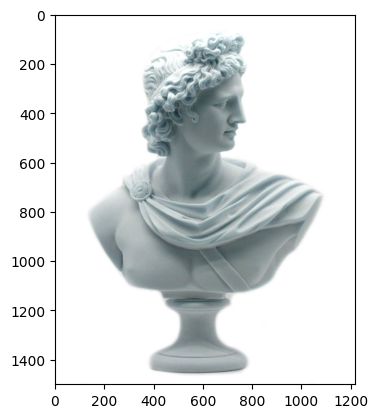

In [ ]:
# Se selecciona una imagen para obtener una primer impresión de las imágenes. Se aprecia que son imágenes a color de buen grado de nitidez
img_color = cv2.imread(image_paths[10])
plt.imshow(img_color)

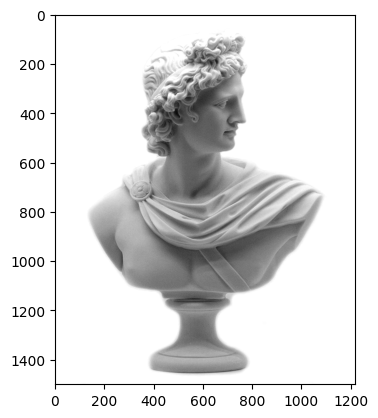

In [ ]:
# Se convierte la imagen a escala de grises
img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

# Generación de clases a partir de los datasets

Number of human images processed: 199
(25472, 128)
(25472,)
Number of non-human images processed: 128
(16384, 128)
(16384,)


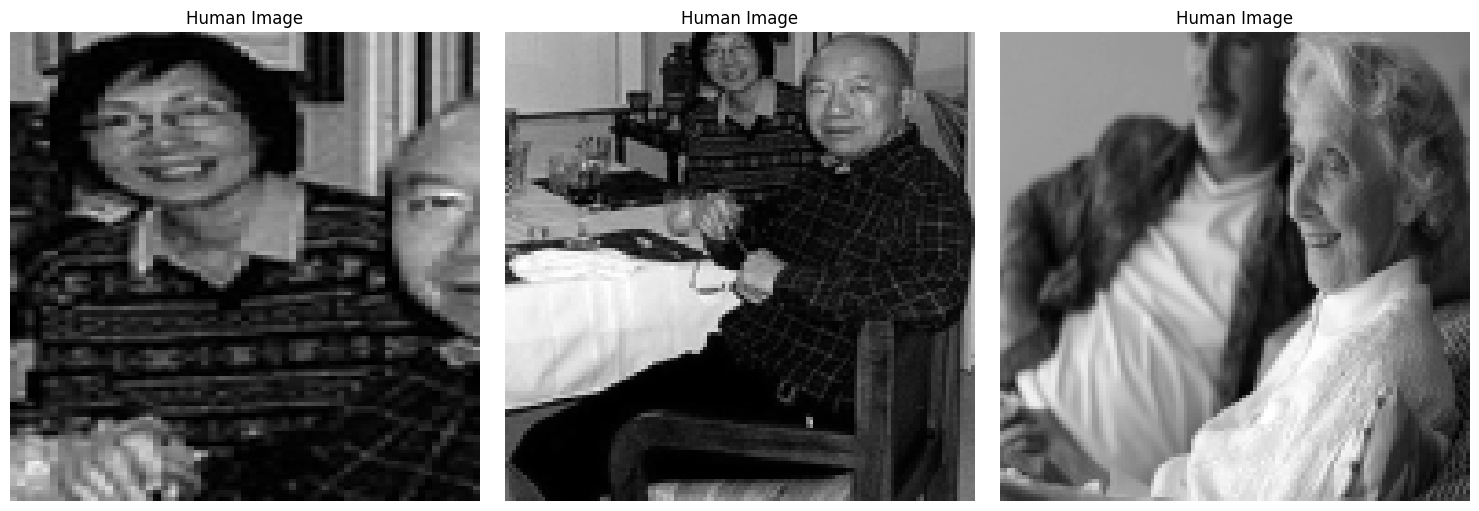

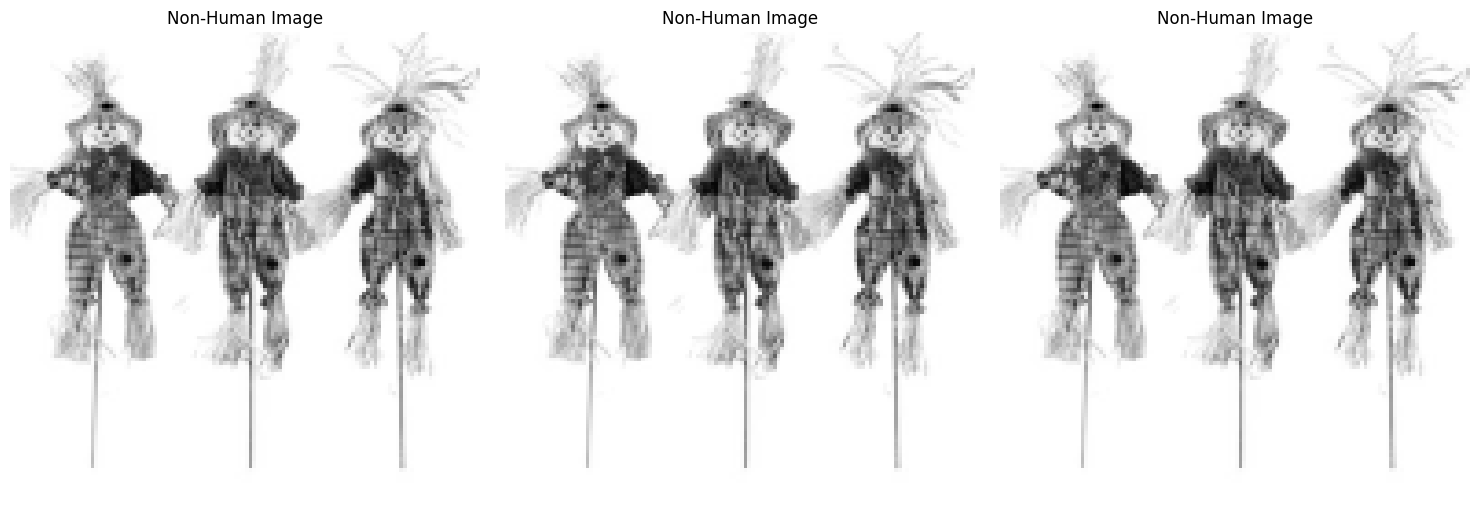

In [ ]:
# A continuación se muestran las configuraciones para los dos sets de datos, uno con personas y otro sin personas
image_size = (128, 128)  # Tamaño de imagenes

def resize_segment(segment, size):
    """ Resize the image segment to the given size. """
    return cv2.resize(segment, size, interpolation=cv2.INTER_AREA)

def is_valid_segment(segment):
    """ Check if the segment size is valid for HOG calculation """
    """ Check if the segment size is valid (non-empty) """
    return segment.size > 0

human_images = []
no_human_images = []

# Procesar imágenes para segmentos humanos.
#human_images_to_show = []
for image_path in image_paths:
    img_name = os.path.splitext(os.path.basename(image_path))[0]

    # Leer imagen
    img_color = mpimg.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    if img_name in annotation_paths:
        # Parse XML
        tree = ET.parse(annotation_paths[img_name])
        root = tree.getroot()

        human_boxes = []

        # Extraer cuadros delimitadores para 'persona'
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == "person":
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                human_boxes.append((xmin, ymin, xmax, ymax))

        # Seleccione una casilla de 'persona' al azar si hay varias
    if len(human_boxes) >= 1:
      selected_boxes = random.sample(human_boxes, len(human_boxes))
      for box in selected_boxes:
          xmin, ymin, xmax, ymax = box
          if xmin < xmax and ymin < ymax:
              human_img_segment = img_gray[ymin:ymax, xmin:xmax]
              if is_valid_segment(human_img_segment):
                  human_img_segment_resized = resize_segment(human_img_segment, image_size)
                  human_images.append(human_img_segment_resized)

# Procesar imágenes para segmentos no humanos (imágenes sin objetos "personas")
#non_human_images_to_show = []
for image_path in image_paths:
    img_name = os.path.splitext(os.path.basename(image_path))[0]

    # Leer imagen
    img_color = mpimg.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    if img_name in annotation_paths:
        # Parse XML
        tree = ET.parse(annotation_paths[img_name])
        root = tree.getroot()

        contains_person = False

        # Verificar la presencia de objetos 'personas'
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == "person":
                contains_person = True
                break

        # Si no se encuentran objetos 'persona', procese la imagen
       #if not contains_person:
            if is_valid_segment(img_gray):
                non_human_img_segment_resized = resize_segment(img_gray, image_size)
                no_human_images.append(non_human_img_segment_resized)

# Convertir listas en matrices numerosas
if human_images:
    X_human = np.vstack(human_images).astype(np.float64)
    y_human = np.ones(len(X_human))
    print(f"Number of human images processed: {len(human_images)}")
    print(X_human.shape)
    print(y_human.shape)
else:
    print("No human features extracted.")
    X_human = np.array([])
    y_human = np.array([])

if no_human_images:
    X_no_human = np.vstack(no_human_images).astype(np.float64)
    y_no_human = np.zeros(len(X_no_human))
    print(f"Number of non-human images processed: {len(no_human_images)}")
    print(X_no_human.shape)
    print(y_no_human.shape)
else:
    print("No non-human features extracted.")
    X_no_human = np.array([])
    y_no_human = np.array([])

#############################################################################################################
# Trazar algunas de las imágenes procesadas.
def plot_image_grid(images, titles=None, grid_size=(3, 3), figsize=(15, 15)):
    """Plot a grid of images."""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(images, axes)):
        if img.ndim == 2:  # grayscale image
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        if titles is not None:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Trazar imágenes humanas y no humanas.
plot_image_grid(human_images, titles=["Human Image"] * len(human_images), grid_size=(1, 3), figsize=(15, 5))
plot_image_grid(no_human_images, titles=["Non-Human Image"] * len(no_human_images), grid_size=(1, 3), figsize=(15, 5))


# Combinación de ambos tipos de datos

In [ ]:
# Tamaño del conjunto X
X = np.vstack((X_human,X_no_human))
X.shape

(41856, 128)

In [ ]:
# Tamaño del conjunto y
y = np.hstack((y_human,y_no_human))
y.shape

(41856,)

# Balanceo de clases

In [ ]:
# Importación de librerias para el balanceo de clases y separación de los conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Calcular los pesos de las clases
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.27475635224504, 1: 0.8226820913124052}


In [ ]:
# Tamaño del conjunto de entrenamiento X
X_train.shape

(29299, 128)

In [ ]:
# Tamaño del conjunto de prueba X
X_test.shape

(12557, 128)

# Normalización de las intensidades de los pixeles en un intervalo de 0 y 1

In [ ]:
# Se normaliza la intensidad de los pixeles, al dividir con 255 de los conjuntos X. Estos seran sus nuevos valores en escala de grises
X_train = X_train/255
X_test = X_test/255

# Definición de modelo
Diseña una red neuronal adecuada para detectar peatones. Toma en cuenta el número de entradas de la red, crea un número adecuado de capas ocultas y crea una capa de salida con una sola neurona con salida binaria.

In [ ]:
# Defición del modelo utilizando secuential para agregar secuencias de capas a la red neuronal
model = Sequential()

model.add(Dense(units = 128, input_dim=128, activation='relu')) # 128 neuronas va recibir 128 features, y una función de activación relu
model.add(Dropout(0.20))  # Se apagan aleatoriamente el 20% de los nodos de la capa siguiente

model.add(Dense(units = 64, activation='relu')) # 64 neuronas con una función de activación relu
model.add(Dropout(0.20)) # Se apagan aleatoriamente el 20% de los nodos de la capa siguiente

model.add(Dense(units = 32, activation='relu')) # 32 neuronas con una función de activación relu
model.add(Dropout(0.20)) # Se apagan aleatoriamente el 20% de los nodos de la capa siguiente

model.add(Dense(units = 10, activation='relu')) # 10 neuronas con una función de activación relu
model.add(Dropout(0.20)) # Se apagan aleatoriamente el 20% de los nodos de la capa siguiente

model.add(Dense(units = 1, activation='sigmoid')) # 1 neurona con una función de activación relu

model.compile(Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy']) # Definición del learning rate, función de pérdida para clasificación binaria y métrica para evaluar el rendimiento del modelo

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 10)               

# Separación de un 10% del set de entrenamiento para fines de validación

In [ ]:
# Tamaño del conjunto de entrenamiento X
X_train.shape

(29299, 128)

In [ ]:
# Tamaño del conjunto de prueba X
X_test.shape

(12557, 128)

In [ ]:
# Tamaño del conjunto de entrenamiento y
y_train.shape

(29299,)

In [ ]:
# Entrenamiento del modelo con los conjuntos de entrenamiento y con un 10% para hacer la validación
history = model.fit(X_train, y_train, validation_split=0.1, epochs = 60, batch_size = 200, verbose = 1, shuffle = 1, class_weight=class_weights_dict)

Epoch 1/60
132/132 [==============================] - 4s 22ms/step - loss: 0.6487 - accuracy: 0.5926 - val_loss: 0.5666 - val_accuracy: 0.7140
Epoch 2/60
132/132 [==============================] - 3s 24ms/step - loss: 0.5702 - accuracy: 0.7072 - val_loss: 0.5108 - val_accuracy: 0.7311
Epoch 3/60
132/132 [==============================] - 3s 21ms/step - loss: 0.5324 - accuracy: 0.7333 - val_loss: 0.4771 - val_accuracy: 0.7584
Epoch 4/60
132/132 [==============================] - 4s 27ms/step - loss: 0.4954 - accuracy: 0.7573 - val_loss: 0.4466 - val_accuracy: 0.7724
Epoch 5/60
132/132 [==============================] - 1s 6ms/step - loss: 0.4723 - accuracy: 0.7659 - val_loss: 0.4139 - val_accuracy: 0.7922
Epoch 6/60
132/132 [==============================] - 3s 21ms/step - loss: 0.4548 - accuracy: 0.7818 - val_loss: 0.4104 - val_accuracy: 0.8003
Epoch 7/60
132/132 [==============================] - 3s 21ms/step - loss: 0.4403 - accuracy: 0.7877 - val_loss: 0.4069 - val_accuracy: 0.7986


In [ ]:
# Se evalua el modelo con el conjunto de prueba
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

393/393 [==============================] - 1s 3ms/step - loss: 0.2287 - accuracy: 0.9036
Test loss: 0.22867678105831146
Test accuracy: 0.9035597443580627


Text(0.5, 0, 'epoch')

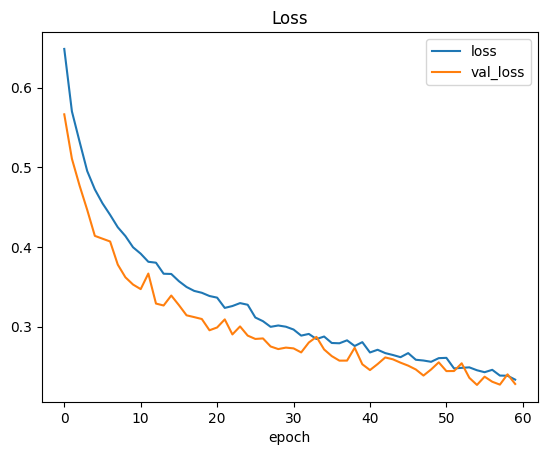

In [ ]:
# Gráfico de comparación de la pérdida del modelo en el conjunto de entrenamiento y validación
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

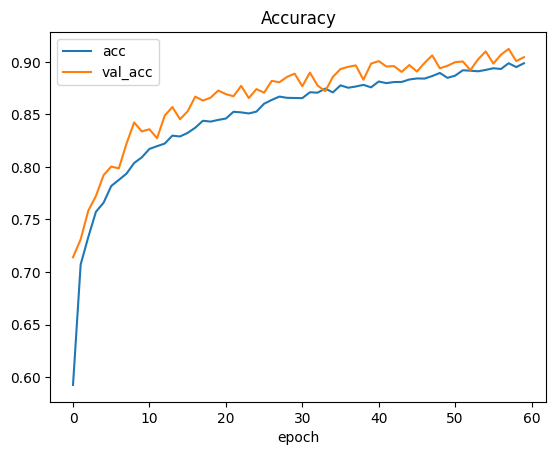

In [ ]:
# Gráfico de comparación de la exactitud del modelo en el conjunto de entrenamiento y validación
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')